In [2]:
import os
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gdp
import rioxarray as rio
from shapely.geometry import mapping

<xarray.DataArray 'sm_sat' ()>
array(0.40332316)
Coordinates:
    soil     int32 1

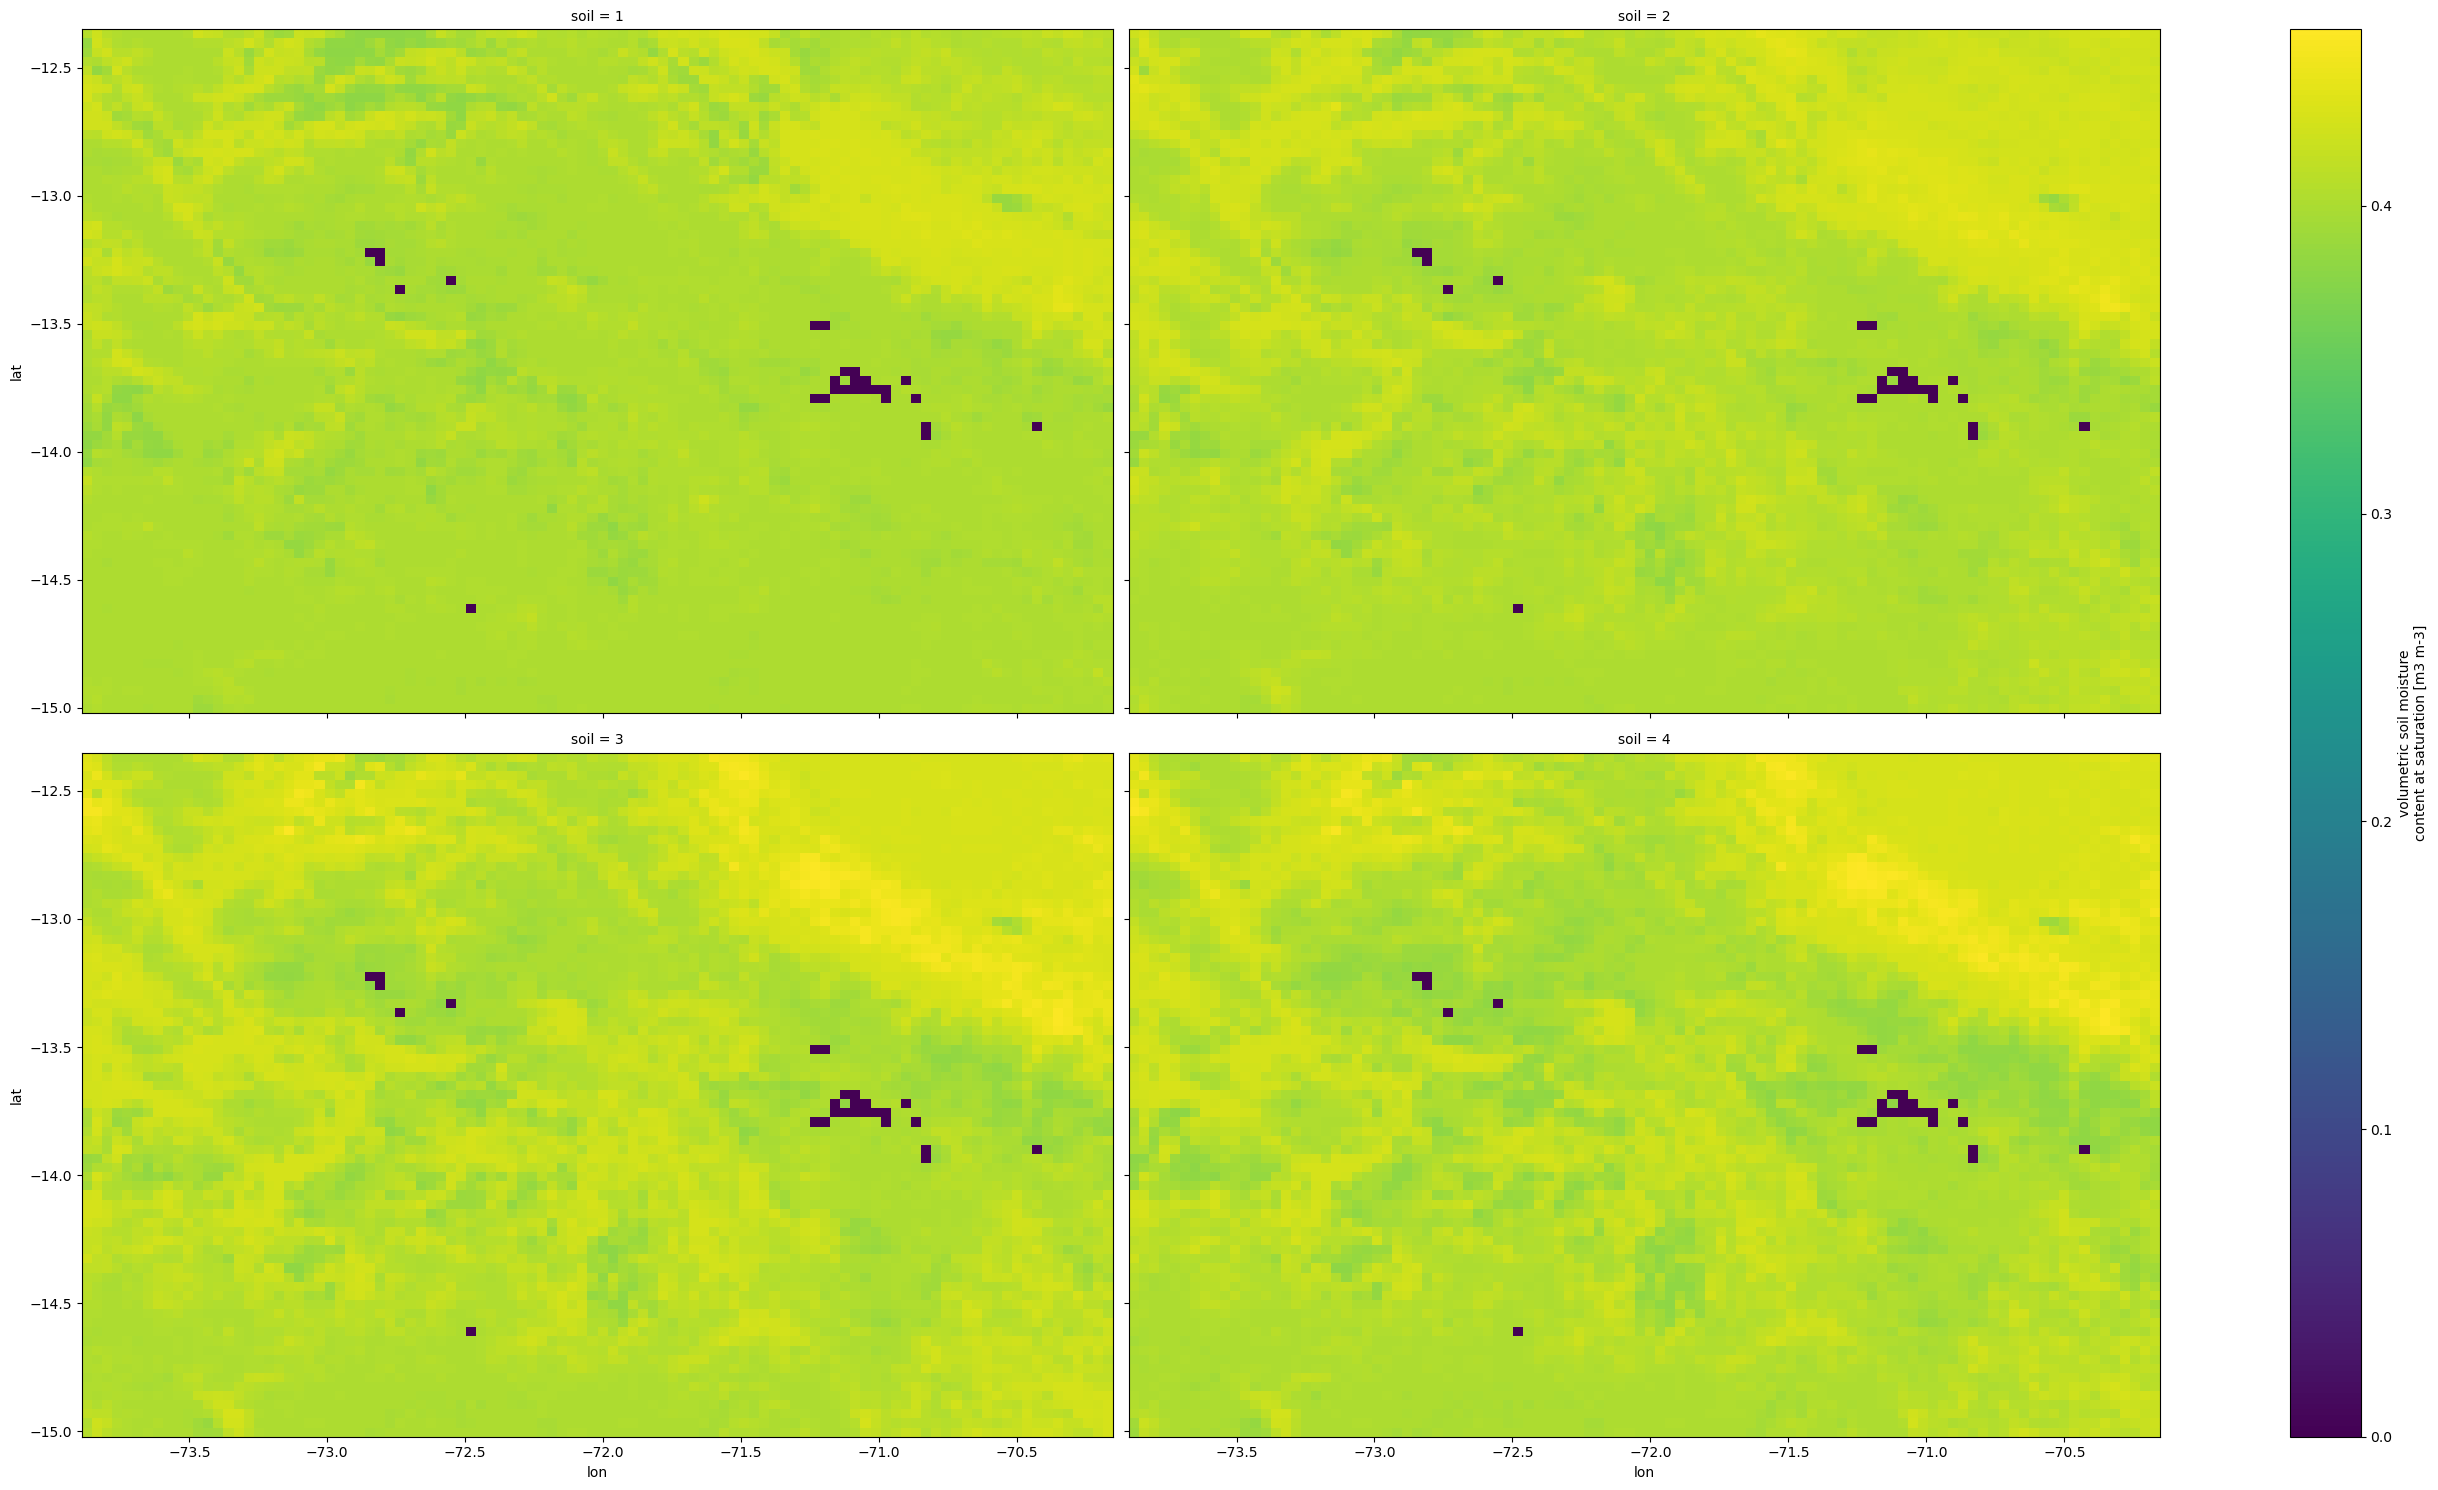

In [3]:
# Create new soil_props file with no ice tiles for new setup runs
soil = xarray.open_dataset("/home/clara/rahu_data/netcdf/jules_soil_props_2015_rosetta3_ESA_rahu.nc")
soil['sm_sat']
fig = soil['sm_sat'].plot(x="lon", y="lat", col="soil", col_wrap=2, figsize=(27,15), aspect=0.5)
soil['sm_sat'][0,:,:].mean()


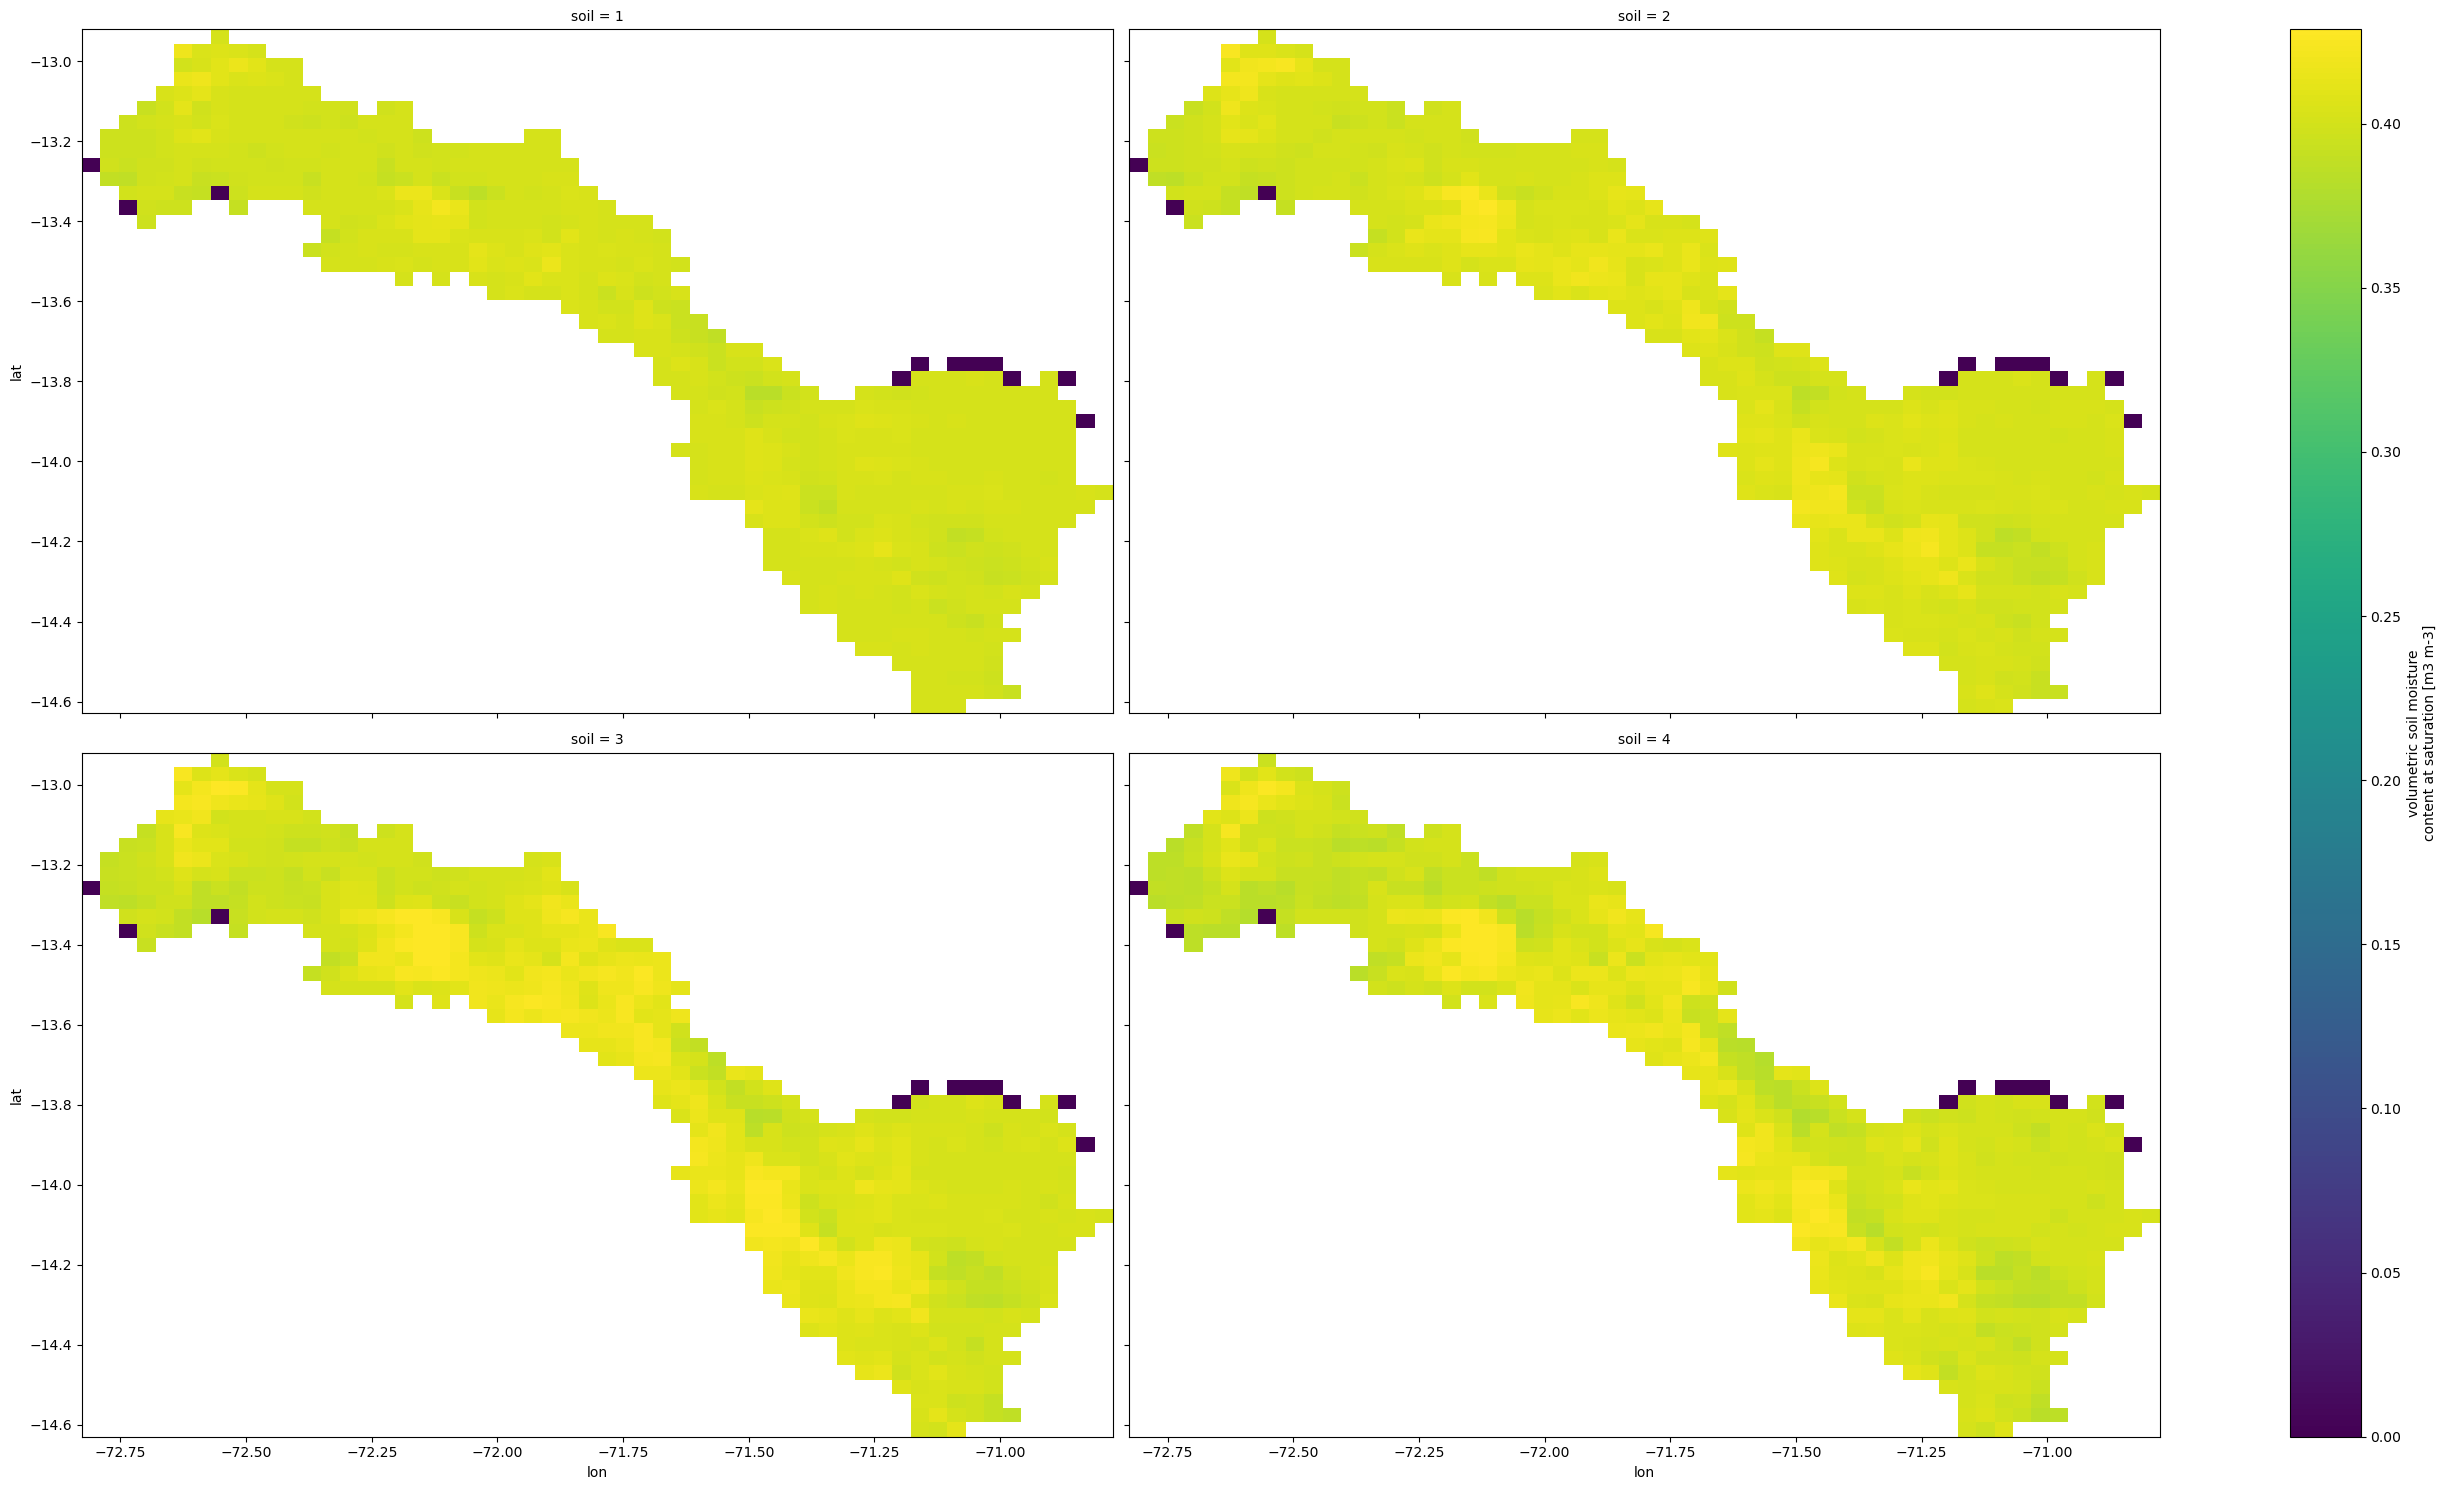

In [7]:
shpfile = gdp.read_file("/home/clara/rahu_data/VUB_studies/VUB_full/cuenca_vilcanota_final.shp")
shpfile = shpfile.to_crs(epsg=4326)

soil.rio.write_crs(4326, inplace=True)

soil_clipped = soil['sm_sat'].rio.clip(shpfile.geometry.apply(mapping), shpfile.crs)
soil_clipped.plot(x="lon", y="lat", col="soil", col_wrap=2, figsize=(27,15), aspect=0.5)


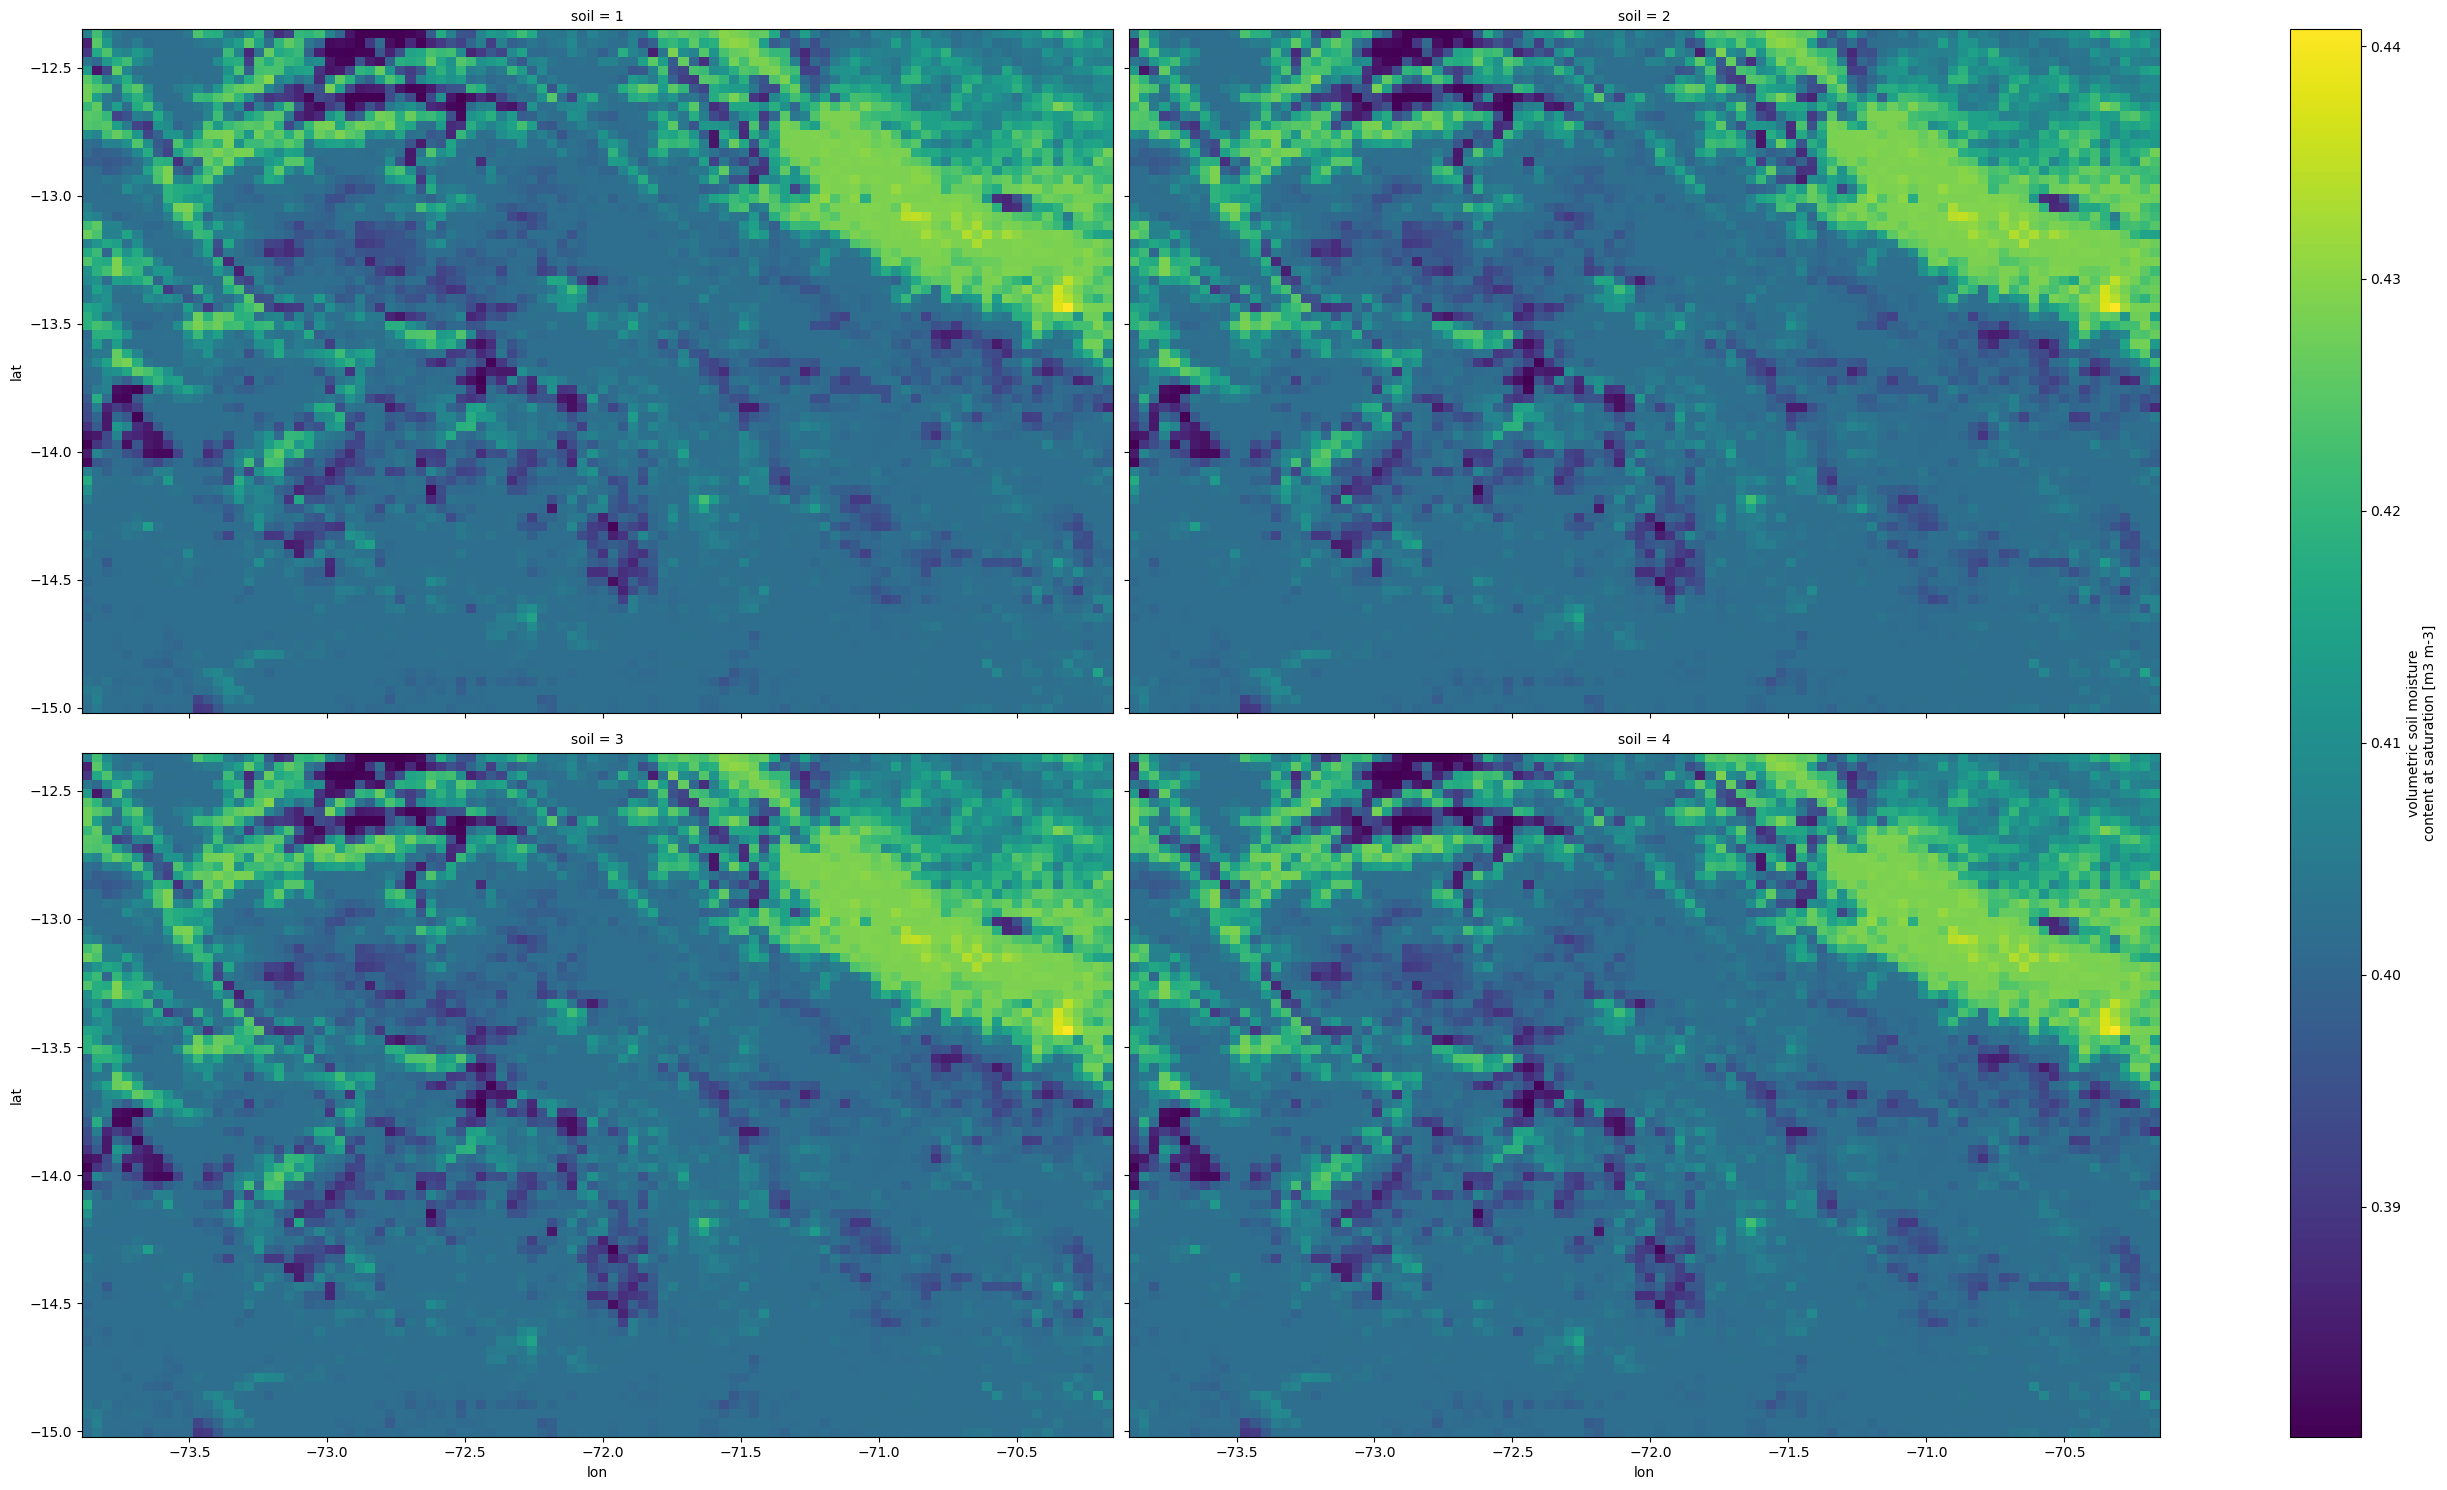

In [8]:
soil_clipped.mean()

# Get the average for the catchment to replace ice tile values with - not 100% correct - can be improved if we get the methodology to derive soil properties file using rosetta - ASK SIMON (08/12/2023)
mean_val = np.zeros(4)
for i in range(4):
    mean_val[i]=soil_clipped[i,:,:].mean()

mean_val

ds = xarray.open_dataset("/home/clara/rahu_data/netcdf/jules_soil_props_2015_rosetta3_ESA_rahu.nc")
ds['sm_sat'][0,:,:]=xarray.where((ds['sm_sat'][0,:,:]==0),mean_val[0],ds['sm_sat'][0,:,:])
ds['sm_sat'][1,:,:]=xarray.where((ds['sm_sat'][1,:,:]==0),mean_val[1],ds['sm_sat'][0,:,:])
ds['sm_sat'][2,:,:]=xarray.where((ds['sm_sat'][2,:,:]==0),mean_val[2],ds['sm_sat'][0,:,:])
ds['sm_sat'][3,:,:]=xarray.where((ds['sm_sat'][3,:,:]==0),mean_val[3],ds['sm_sat'][0,:,:])
ds.to_netcdf("/home/clara/rahu_data/netcdf/jules_soil_props_2015_rosetta3_ESA_rahu_modified.nc")

# Now check results are correct
new = xarray.open_dataset("/home/clara/rahu_data/netcdf/jules_soil_props_2015_rosetta3_ESA_rahu_modified.nc")
new['sm_sat'].plot(x="lon", y="lat", col="soil", col_wrap=2, figsize=(27,15), aspect=0.5)